In [ ]:
import torch
import math
import random
import numpy as np

from datasets import Recipe1MDataset
from time import time
from torch import nn
from models import TextEncoder, ImageEncoder
from helper import calculate_metrics
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from tqdm import tqdm
from pprint import pprint

In [ ]:
def generate_transformer_input(image_features, text_features, src_key_padding_mask, model):
    image_features *= math.sqrt(model.d_model)
    text_features *= math.sqrt(model.d_model)

    batch_size = image_features.shape[0]
    cls_token = model.cls_token.expand(batch_size, -1, -1)
    image_features = torch.cat((cls_token, image_features), dim=1)
    image_features = image_features + model.image_pos_embed
    image_features = model.image_pos_drop(image_features)

    text_features = model.text_pos_embed(text_features)

    sep_token = model.sep_token.expand(batch_size, -1, -1)
    transformer_input = torch.cat((image_features, sep_token, text_features), dim=1)
    if src_key_padding_mask is not None:
        src_key_padding_mask = torch.cat((torch.zeros(batch_size, image_features.shape[1] + 1).to(transformer_input.device), src_key_padding_mask), dim=1)
        
    return transformer_input, src_key_padding_mask

In [ ]:
def extract_self_attention_maps(transformer_encoder, x, src_key_padding_mask):
    attention_maps = []
    num_layers = transformer_encoder.num_layers
    num_heads = transformer_encoder.layers[0].self_attn.num_heads
    norm_first = transformer_encoder.layers[0].norm_first
    with torch.no_grad():
        for i in range(num_layers):
            # compute attention of layer i
            h = x.clone()
            if norm_first:
                h = transformer_encoder.layers[i].norm1(h)
            attn = transformer_encoder.layers[i].self_attn(h, h, h,
                                                           key_padding_mask=src_key_padding_mask,
                                                           need_weights=True)[1]
            attention_maps.append(attn)
            # forward of layer i
            x = transformer_encoder.layers[i](x,src_key_padding_mask=src_key_padding_mask)
    return attention_maps


In [10]:
def show(d, i):
    import matplotlib.pyplot as plt
    txt, img = d[i]
    print(txt.split('\n')[0])
    npimg = img.numpy()
    npimg = (npimg-npimg.min()) / (npimg.max()-npimg.min())
#     print(np.transpose(npimg, (1,2,0)))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [260]:
val_dataset[3][0].split('\n')[1:-1]

['all - purpose flour',
 'walnuts',
 'brown sugar',
 'butter',
 'strawberries',
 'white sugar',
 'lemon juice',
 'frozen whipped topping',
 'Preheat oven to 350 degrees F (175 degrees C).',
 'To make the crust: combine flour, nuts, and brown sugar.',
 'Add melted butter, tossing to combine the ingredients.',
 'Spread the mixture in a 9x13 inch pan.',
 'Bake the crust at 350 degrees F (175 degrees C) for 15 minutes, stirring occasionally until lightly browned.',
 'Remove from pan and set aside to cool.',
 'Sprinkle 1 1/2 cups crust mixture in a 9x13 inch pan.',
 'Reserve the remaining crust mixture.',
 'Filling: In large bowl combine strawberries, sugar and lemon juice.',
 'Fold whipped topping into the mixture.',
 'Carefully spoon filling over the crust mixture.',
 'Sprinkle the remaining crust mixture on top.',
 'Cover and freeze for 6 hours or until firm.']

In [39]:
i = 3
j = 3

In [40]:
i_f = image_features[i].unsqueeze(0).to(device)
t_f = text_embeddings[j].unsqueeze(0).to(device)
a_m = ~attention_masks[j].unsqueeze(0).bool().to(device)

t_input, mask = generate_transformer_input(i_f, t_f, a_m, u_transformer)

In [41]:
attention = extract_self_attention_maps(u_transformer.encoder, t_input, mask)

In [42]:
t_f[~a_m].shape

torch.Size([189, 768])

In [43]:
t_input.shape

torch.Size([1, 396, 768])

In [44]:
attention[1].shape

torch.Size([1, 396, 396])

In [45]:
text_tokens = tokenizer(val_dataset[3][0], truncation=True, padding=True, return_tensors="pt").to(device)

In [46]:
text_tokens.input_ids.shape

torch.Size([1, 189])

In [47]:
tokenizer.convert_ids_to_tokens(text_tokens.input_ids.tolist()[0])[3]

'strawberry'

In [65]:
attention[1][0][202]

tensor([0.0005, 0.0014, 0.0021, 0.0016, 0.0006, 0.0019, 0.0016, 0.0017, 0.0018,
        0.0013, 0.0014, 0.0018, 0.0013, 0.0035, 0.0019, 0.0039, 0.0015, 0.0016,
        0.0008, 0.0014, 0.0017, 0.0015, 0.0041, 0.0017, 0.0017, 0.0000, 0.0018,
        0.0015, 0.0015, 0.0021, 0.0017, 0.0042, 0.0016, 0.0031, 0.0035, 0.0017,
        0.0022, 0.0005, 0.0036, 0.0018, 0.0019, 0.0015, 0.0018, 0.0015, 0.0052,
        0.0016, 0.0014, 0.0017, 0.0016, 0.0019, 0.0016, 0.0015, 0.0017, 0.0014,
        0.0014, 0.0006, 0.0015, 0.0022, 0.0000, 0.0017, 0.0011, 0.0015, 0.0012,
        0.0006, 0.0015, 0.0036, 0.0019, 0.0012, 0.0017, 0.0018, 0.0013, 0.0005,
        0.0013, 0.0009, 0.0017, 0.0016, 0.0013, 0.0019, 0.0035, 0.0038, 0.0014,
        0.0015, 0.0035, 0.0017, 0.0009, 0.0007, 0.0012, 0.0029, 0.0041, 0.0016,
        0.0015, 0.0015, 0.0016, 0.0019, 0.0046, 0.0047, 0.0015, 0.0027, 0.0015,
        0.0049, 0.0004, 0.0009, 0.0026, 0.0019, 0.0000, 0.0014, 0.0029, 0.0014,
        0.0018, 0.0017, 0.0011, 0.0007, 

In [66]:
highest_attended = attention[1][0][202].argsort().tolist()[::-1][:10]
highest_attended

[394, 393, 389, 391, 390, 392, 388, 269, 44, 293]

In [67]:
attention[1][0][202][highest_attended]

tensor([0.0103, 0.0095, 0.0095, 0.0092, 0.0083, 0.0075, 0.0072, 0.0056, 0.0052,
        0.0050], device='cuda:7')

In [51]:
text_tokens

{'input_ids': tensor([[  101, 10097,  2100, 16876, 14320,  2035,  1011,  3800, 13724, 18489,
          2015,  2829,  5699, 12136, 13137, 20968,  2317,  5699, 14380, 10869,
          7708, 12428, 22286,  3653, 20192,  2102, 17428,  2000,  8698,  5445,
          1042,  1006, 12862,  5445,  1039,  1007,  1012,  2000,  2191,  1996,
         19116,  1024, 11506, 13724,  1010, 12264,  1010,  1998,  2829,  5699,
          1012,  5587, 12501, 12136,  1010, 15021,  2000, 11506,  1996, 12760,
          1012,  3659,  1996,  8150,  1999,  1037,  1023,  2595, 17134,  4960,
          6090,  1012,  8670,  3489,  1996, 19116,  2012,  8698,  5445,  1042,
          1006, 12862,  5445,  1039,  1007,  2005,  2321,  2781,  1010, 18385,
          5681,  2127,  8217, 15005,  2094,  1012,  6366,  2013,  6090,  1998,
          2275,  4998,  2000,  4658,  1012, 11867,  6657, 19099,  1015,  1015,
          1013,  1016, 10268, 19116,  8150,  1999,  1037,  1023,  2595, 17134,
          4960,  6090,  1012,  3914,  

In [228]:
sum(attention[0][0][0])

tensor(1.0072, device='cuda:7')

In [238]:
attention[0][0][0].shape

torch.Size([396])

In [68]:
image_attentions = attention[1][0][202][1:198]
text_attentions = attention[1][0][202][199:]
image_attentions.shape, text_attentions.shape

(torch.Size([197]), torch.Size([197]))

In [69]:
patch_attentions = image_attentions[1:]
patch_attentions.shape

torch.Size([196])

In [70]:
temp = patch_attentions.view(224 // 16, -1)
temp.shape

torch.Size([14, 14])

In [71]:
patch_attentions

tensor([0.0021, 0.0016, 0.0006, 0.0019, 0.0016, 0.0017, 0.0018, 0.0013, 0.0014,
        0.0018, 0.0013, 0.0035, 0.0019, 0.0039, 0.0015, 0.0016, 0.0008, 0.0014,
        0.0017, 0.0015, 0.0041, 0.0017, 0.0017, 0.0000, 0.0018, 0.0015, 0.0015,
        0.0021, 0.0017, 0.0042, 0.0016, 0.0031, 0.0035, 0.0017, 0.0022, 0.0005,
        0.0036, 0.0018, 0.0019, 0.0015, 0.0018, 0.0015, 0.0052, 0.0016, 0.0014,
        0.0017, 0.0016, 0.0019, 0.0016, 0.0015, 0.0017, 0.0014, 0.0014, 0.0006,
        0.0015, 0.0022, 0.0000, 0.0017, 0.0011, 0.0015, 0.0012, 0.0006, 0.0015,
        0.0036, 0.0019, 0.0012, 0.0017, 0.0018, 0.0013, 0.0005, 0.0013, 0.0009,
        0.0017, 0.0016, 0.0013, 0.0019, 0.0035, 0.0038, 0.0014, 0.0015, 0.0035,
        0.0017, 0.0009, 0.0007, 0.0012, 0.0029, 0.0041, 0.0016, 0.0015, 0.0015,
        0.0016, 0.0019, 0.0046, 0.0047, 0.0015, 0.0027, 0.0015, 0.0049, 0.0004,
        0.0009, 0.0026, 0.0019, 0.0000, 0.0014, 0.0029, 0.0014, 0.0018, 0.0017,
        0.0011, 0.0007, 0.0019, 0.0007, 

In [72]:
from matplotlib import pyplot as plt

In [73]:
temp.cpu().numpy() / temp.max().item()

array([[0.40829608, 0.3166931 , 0.10677969, 0.37367812, 0.30060998,
        0.31987503, 0.3452397 , 0.25296125, 0.27710885, 0.33892104,
        0.2513469 , 0.67080575, 0.36116382, 0.74565405],
       [0.29687425, 0.31209093, 0.15276535, 0.26560417, 0.3195804 ,
        0.29287744, 0.78940403, 0.33299428, 0.3294022 , 0.        ,
        0.34418267, 0.2920081 , 0.2968449 , 0.40388545],
       [0.3198636 , 0.8108402 , 0.30106214, 0.6083982 , 0.6681258 ,
        0.33294436, 0.4227368 , 0.09119248, 0.6906195 , 0.34540552,
        0.36918253, 0.28701407, 0.34835985, 0.29731214],
       [1.        , 0.30246186, 0.26126465, 0.3221836 , 0.30473155,
        0.3586105 , 0.3145899 , 0.2981902 , 0.32727557, 0.26500028,
        0.26383525, 0.11816143, 0.28760675, 0.4182925 ],
       [0.        , 0.32941544, 0.21046667, 0.29628518, 0.22477445,
        0.115891  , 0.29622626, 0.689841  , 0.36289623, 0.23928215,
        0.32637367, 0.34617284, 0.24351439, 0.09585183],
       [0.2521176 , 0.17629723, 0.3

Frosty Strawberry Squares


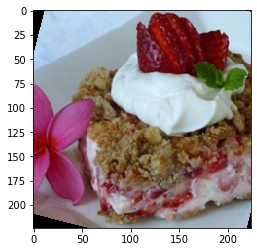

In [110]:
show(val_dataset, 3)

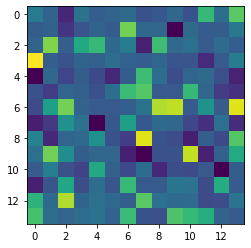

In [75]:
plt.imshow(temp.cpu().numpy() / temp.max().item())